# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd /home/jovyan/dea_intertidal/dea-intertidal/

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
# pip install -r requirements.in --quiet

### Load packages

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry

from intertidal.utils import (
    load_config,
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset
from intertidal.tidelines import tidal_offset_tidelines

## Setup


### Set analysis parameters

In [34]:
# Set study area and config
study_area = "Lake Tyers Vic"
# config_path = "configs/dea_intertidal_config_development.yaml"
# study_area = '1215'
config_path='configs/dea_intertidal_config.yaml'

# Intertidal Elevation variables
start_date = "2018"  # Start date for analysis
end_date = "2020"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### *Optional: override study area selection using interactive map*
> *Guide: for 10m2 pixels, analysis area of 90km2 takes ~XXXX mins to run full workflow on 16XL sandbox instance*

In [35]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                       layers=(basemap,),
                       center=(-26, 135),
                       zoom=4)
study_area = geom

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Intertidal workflow

### Intertidal elevation

In [36]:
# Model elevation for each pixel
ds, freq, corr, tide_m = elevation(
    study_area=study_area,
    start_date=start_date,
    end_date=end_date,
    config_path=config_path,
)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/46725/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/46725/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40411,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/46725/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:37139,Total threads: 62
Dashboard: /user/claire.phillips@ga.gov.au/proxy/45257/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:40641,


2023-05-01 06:11:05 INFO Study area testing: Loaded custom study area
2023-05-01 06:11:05 INFO Study area testing: Loading satellite data
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-05-01 06:12:11 INFO Study area testing: Modelling tide heights for each pixel


Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 401/401 [00:00<00:00, 626.06it/s]
2023-05-01 06:12:22 INFO Study area testing: Masking nodata and adding tide heights to satellite data array
2023-05-01 06:12:22 INFO Study area testing: Flattening satellite data array and filtering to tide influenced pixels
2023-05-01 06:12:24 INFO Study area testing: Running per-pixel rolling median


Reducing analysed pixels from 103155 to 1352 (1.31%)


100%|██████████| 114/114 [00:00<00:00, 125.71it/s]
2023-05-01 06:12:26 INFO Study area testing: Modelling intertidal elevation and confidence
2023-05-01 06:12:26 INFO Study area testing: Successfully completed intertidal elevation modelling


Processing elevation_low
Processing elevation
Processing elevation_high


### Intertidal extents

#### Always/sometimes/never wet

Values of 0 represent always wet, 1 is the extent of the DEA intertidal product suite and 2 represents never wet

In [ ]:
ds['extents'], wet_ext = extents(ds.elevation, freq, corr)

### Intertidal exposure
Calculate exposure using the script function

In [ ]:
ds['exposure'], tide_cq = exposure(ds.elevation, all_timerange)

### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [ ]:
(ds['lat'], 
 ds['hat'], 
 ds['lot'], 
 ds['hot'], 
 ds['spread'], 
 ds['offset_lowtide'],
 ds['offset_hightide']) = bias_offset(tide_m=tide_m,
                                      tide_cq=tide_cq,
                                      extents=ds.extents,
                                      lot_hot=True,
                                      lat_hat=True)

### Tideline confidence

In [ ]:
(hightideline, 
 lowtideline, 
 tidelines_gdf) = tidal_offset_tidelines(extents=ds.extents,
                                         offset_hightide=ds.offset_hightide,
                                         offset_lowtide=ds.offset_lowtide,
                                         distance=250)

## Plot all layers

In [ ]:
# Inspect contents of ds before plotting
ds

In [ ]:
# Set up figure
fig = plt.figure(figsize=(10, 25))
ax1 = fig.add_subplot(6, 2, 1)
ax2 = fig.add_subplot(6, 2, 2)
ax3 = fig.add_subplot(6, 2, 3)
ax4 = fig.add_subplot(6, 2, 4)
ax5 = fig.add_subplot(6, 2, 5)
ax6 = fig.add_subplot(6, 2, 6)
ax7 = fig.add_subplot(6, 2, 7)
ax8 = fig.add_subplot(6, 2, 8)
ax9 = fig.add_subplot(6, 2, 9)
ax10 = fig.add_subplot(6, 2, 10)
ax11 = fig.add_subplot(6, 2, 11)
ax12 = fig.add_subplot(6, 2, 12)

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(ax=ax1, cmap="viridis", interpolation="bilinear")
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).plot.imshow(
    ax=ax1, interpolation="bilinear"
)
ax1.set_title("Elevation (metres AMSL)")

# Plot Exposure
ds["exposure"].where(ds["exposure"] > 0).plot.imshow(
    ax=ax2, cmap="RdYlGn", levels=np.arange(0, 100, 1)
)
ax2.set_title("Exposure-% of time")

# Plot the always/sometimes/never wet extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax3)
ax3.set_title("Wet, Dry and Intertidal extent")

# Plot the observation spread
ds["spread"].where((ds["extents"] != 2) & (ds["spread"] > 0)).plot.imshow(
    ax=ax4, vmin=0, vmax=100, cmap="magma", cbar_kwargs={"label": "% spread"}
)
ax4.set_title("Observation Spread")

# Plot the high-tide offset
ds["offset_hightide"].where((ds["extents"] != 2) & (ds["spread"] > 0)).plot.imshow(
    ax=ax5, vmin=0, vmax=40, cmap="magma", cbar_kwargs={"label": "% high tide offset"}
)
ax5.set_title("High-tide offset")

# Plot the low-tide offset
ds["offset_lowtide"].where((ds["extents"] != 2) & (ds["spread"] > 0)).plot.imshow(
    ax=ax6, vmin=0, vmax=40, cmap="magma", cbar_kwargs={"label": "% low tide offset"}
)
ax6.set_title("Low-tide offset")

# Plot the LAT
ds["lat"].where(ds["extents"] != 2).plot.imshow(
    ax=ax7, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax7.set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["lot"].where(ds["extents"] != 2).plot.imshow(
    ax=ax8, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax8.set_title("Lowest Observed Tide")

# Plot the HAT
ds["hat"].where(ds["extents"] != 2).plot.imshow(
    ax=ax9, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax9.set_title("Highest Astronomical Tide")

# Plot the HOT
ds["hot"].where(ds["extents"] != 2).plot.imshow(
    ax=ax10, vmin=ds["lat"].min(), vmax=ds["hat"].max()
)
ax10.set_title("Highest Observed Tide")

# Plot the high and low tidelines with respective offset
ax11.set_title("Lowtide line and lowtide offset")
lowtideline.plot(
    column="offset_lowtide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax11,
    zorder=2,
)
tidelines_gdf.loc[[0], "geometry"].plot(ax=ax11, zorder=1)
ax11.set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax11.set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax12.set_title("Hightide line and hightide offset")
hightideline.plot(
    column="offset_hightide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax12,
    zorder=2,
)
tidelines_gdf.loc[[1], "geometry"].plot(ax=ax12, zorder=1)
ax12.set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax12.set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

fig.tight_layout()
plt.show()

In [ ]:
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).odc.write_cog('testing.tif')

## Export layers

In [ ]:
# If a custom area was selected from the map, use "testing" for output files
if isinstance(study_area, Geometry):
    study_area = "testing"

In [ ]:
# Export figure
fig.savefig(f"data/figures/{study_area}_{start_date}_{end_date}.png")

In [ ]:
# Save rasters as GeoTIFFs
export_intertidal_rasters(ds, prefix=f"data/interim/{study_area}_{start_date}_{end_date}")

In [ ]:
# Export vector files
hightideline.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_offset_hightide.geojson")
lowtideline.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_offset_lowtide.geojson")
tidelines_gdf.to_crs("EPSG:4326").to_file(f"data/interim/{study_area}_{start_date}_{end_date}_tidelines_highlow.geojson")

In [37]:
wet_ext, int_ext, dry_ext, wet_nontidal = extents(ds.elevation, freq, corr)

In [38]:
# int_ext = int_ext.combine_first(wet_ext)
# int_ext = int_ext.combine_first(dry_ext)
# # int_ext = int_ext.combine_first(wet_nontidal)

# int_ext.plot()

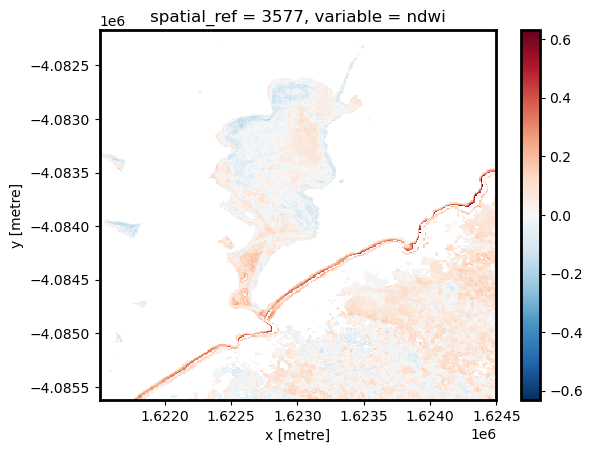

In [39]:
wetdrycorr = corr.where(ds.elevation.isnull())
wetdrycorr.plot()
# corr.where((corr>-0.05)&(corr<0.05)).plot()
# corr.where(corr<0).plot()

(array([1.1100e+02, 2.5110e+03, 1.4255e+04, 1.3899e+04, 2.6250e+03,
        3.6800e+02, 2.1700e+02, 7.9000e+01, 3.1000e+01, 1.2000e+01]),
 array([-0.22588804, -0.14023774, -0.05458744,  0.03106286,  0.11671316,
         0.20236346,  0.28801375,  0.37366405,  0.45931435,  0.54496465,
         0.63061495]),
 <BarContainer object of 10 artists>)

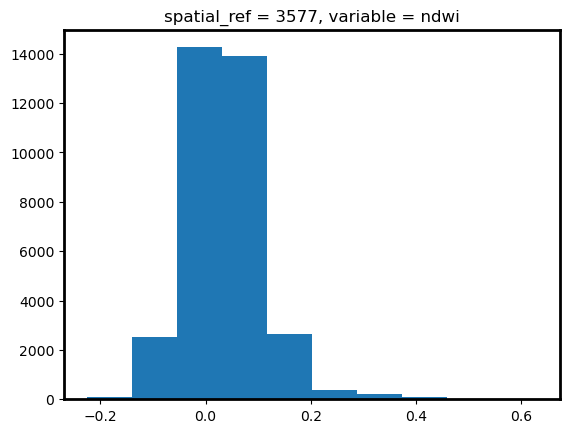

In [40]:
wetdrycorr.plot.hist()

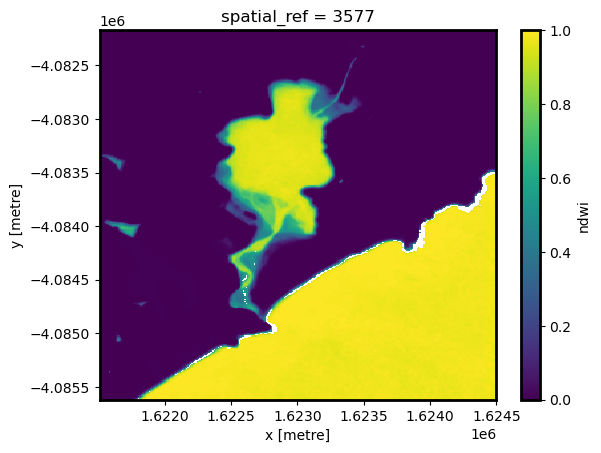

In [41]:
wetdry = freq.where(ds.elevation.isnull())
wetdry.plot()

(array([62458.,   916.,   927.,   934.,   742.,   696.,   652.,   893.,
         1209., 33099.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

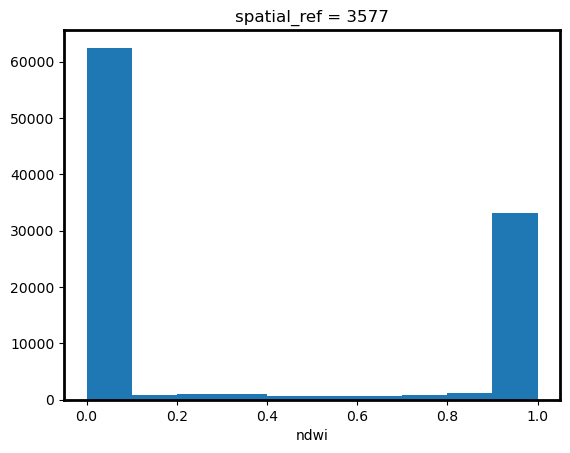

In [42]:
wetdry.plot.hist()

Text(0.5, 1.0, 'Intertidal:0, Wet:1, Dry:2, Other:3')

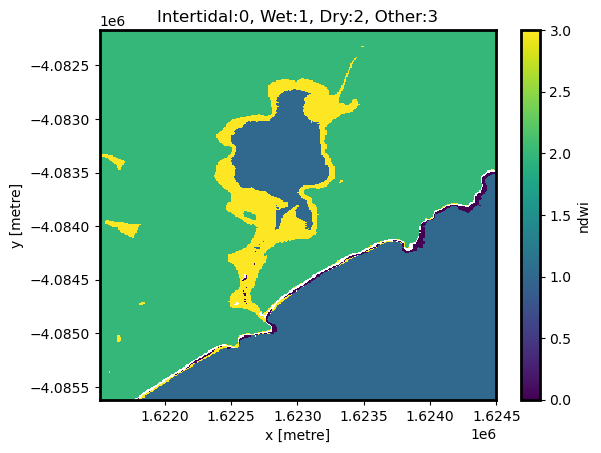

In [78]:
testint = freq.where(ds.elevation.notnull())
# wetdry = freq.where(ds.elevation.isnull())
testwet = wetdry.where(wetdry >= 0.9, drop=True)
testdry = wetdry.where((wetdry <= 0.1), drop=True)
## Other includes all intermittently wet pixels with less than 0.2 correlation to tide
testother = wetdry.where((wetdry > 0.1) & (wetdry < 0.9) & (wetdrycorr <= 0.2), drop=True)
# testother = wetdry.where((wetdry > 0.05) & (wetdry < 0.95), drop=True)

testint = testint.where(testint.isnull(), 0)
testwet = testwet.where(testwet.isnull(), 1)
testdry = testdry.where(testdry.isnull(), 2)
testother = testother.where(testother.isnull(), 3)

intext = testint.combine_first(testwet)
intext = intext.combine_first(testdry)
intext = intext.combine_first(testother)

## Fill missing values with always dry classification
## Missing values are intermittently wet pixels with a correlation to tide greater than 
## `min_correlation` (default 0.2) from intertidal.elevation.ds_to_flat
## 
# intext = intext.fillna(2)

intext.plot()
plt.title('Intertidal:0, Wet:1, Dry:2, Other:3')

(array([ 647.,  604.,  648.,  611.,  512.,  515.,  482.,  554.,  768.,
        1033.]),
 array([0.10040161, 0.18032129, 0.26024096, 0.34016064, 0.42008032,
        0.5       , 0.57991968, 0.65983936, 0.73975904, 0.81967871,
        0.89959839]),
 <BarContainer object of 10 artists>)

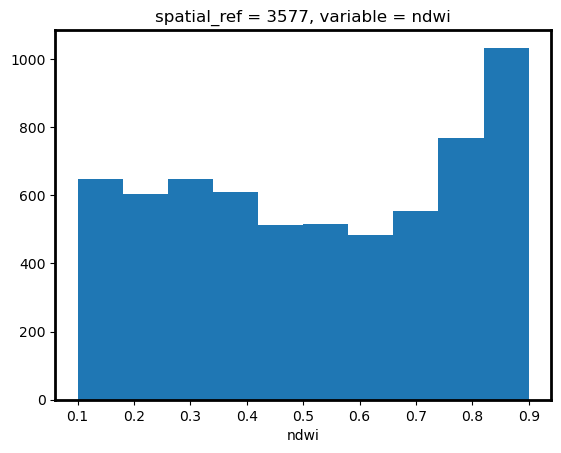

In [81]:
# freq.where(intext.isnull()).plot.hist()
freq.where(intext == 3).plot.hist()

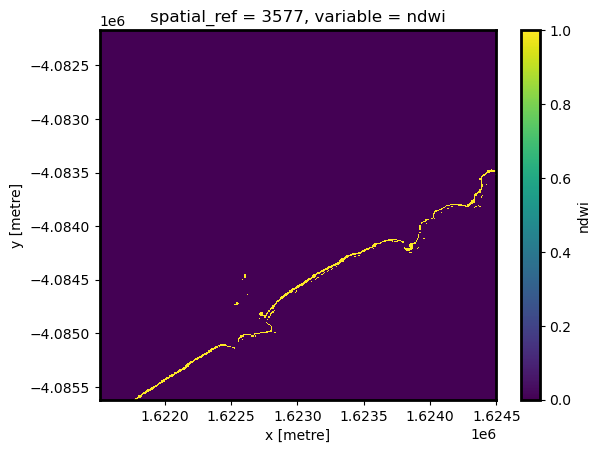

In [60]:
intext.isnull().plot()

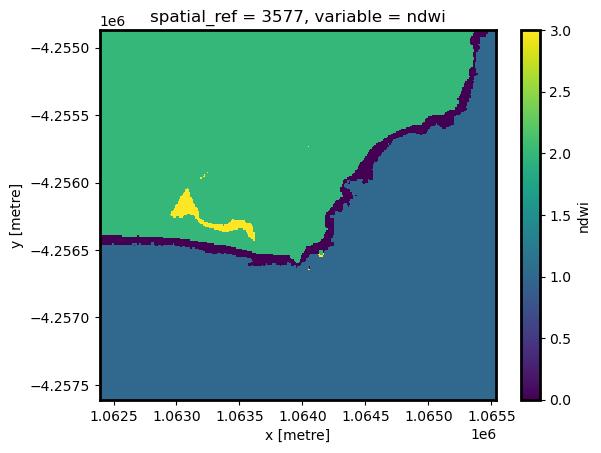

In [32]:

intext.plot()

In [ ]:
int_ext.plot()

In [ ]:
fig, (ax,ax1,ax2) = plt.subplots(3, figsize=(6,12))

wet_ext.plot(ax=ax)
int_ext.plot(ax=ax1)
dry_ext.plot(ax=ax2)

In [ ]:
fig, (ax,ax1) = plt.subplots(2, figsize=(6,8))#1,1)
# wet_ext.plot(ax=ax)
# wn.plot(ax=ax1)
corr.plot(ax=ax)
freq.plot(ax=ax1)

(array([36791.,   331.,   303.,   420.,   595.,   541.,   378.,   369.,
         2166., 44416.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

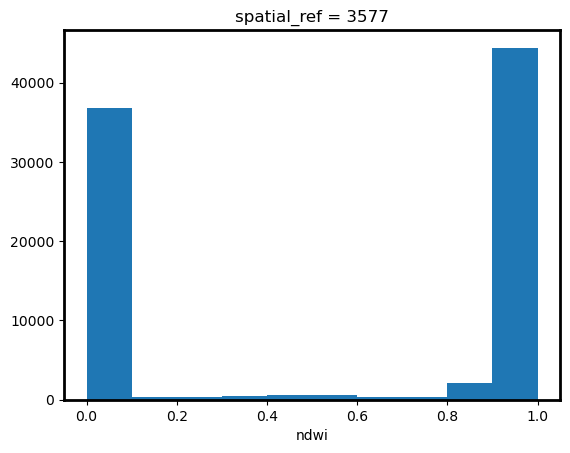

In [15]:
freq.plot.hist()

In [ ]:
corr.plot.hist()

In [ ]:
fig, (ax,ax1) = plt.subplots(2, figsize=(6,8))#1,1)
# wet_ext.plot(ax=ax1)
# wn.plot(ax=ax)
filt_corr.plot(ax=ax)
filt_freq.plot(ax=ax1)

In [ ]:
filt_corr = corr.where(corr<0.2)
filt_freq = freq.where(filt_corr.notnull())

In [ ]:
freq.where(ds.elevation.isnull()).where(freq>= 0.8).plot()

In [ ]:
freq.where((ds.elevation.isnull())&(freq>= 0.9)&(corr<0)).plot()

In [ ]:
freq.where((ds.elevation.isnull())&(freq< 0.9)).plot()

In [ ]:
freq.where((ds.elevation.isnull())&(freq> 0.8)&(corr<0)).plot()

In [ ]:
freq.where((ds.elevation.isnull())&(freq< 0.8)&(corr<0)).plot()

In [ ]:
freq.where(ds.elevation.isnull()).where((freq>= 0.8)&(corr<0.2)).min()

In [ ]:
freq.where(ds.elevation.isnull()).plot.hist()

In [ ]:
corr.where(ds.elevation.isnull()).plot()

In [ ]:
corr.where(ds.elevation.isnull()).plot.hist()

In [ ]:
# wet_ext.where((corr < 0.2) & (corr < 0)).plot()
wn = wet_ext.where(corr < 0)
wn = wn.where(wn.isnull(), 3)
# wet_ext_test = wet_ext.where(wn.notnull(), 0)

# wet_ext_test.plot()
# wet_ext.plot()
# wet_nontidal.plot()
# wn.plot()

In [ ]:
wt = wet_ext.where(wn != 3).plot()

In [ ]:
# corr.plot()
# fig, ax = plt.figure()
corr.plot()
wet_ext.plot()#ax=ax)
# wn.plot()
#ax=ax)
# plt.show()

In [ ]:
wet_ext.plot()

In [ ]:
corr.where(corr>0.2).plot()

In [ ]:
corr.where(corr<=0.2).plot()
wn.plot()
wet_ext.plot()

In [ ]:
wet_ext.notnull().plot()

In [ ]:
# 
wet_ext.where(corr<0).plot()

In [ ]:
wet = ds['extents'].where(ds.extents == 0)#.plot()

In [ ]:
corr.where(corr<0).plot()

In [ ]:
ephem_nontidal = corr.where(corr<0).where(wet.notnull())
ephem_nontidal.plot()

In [ ]:
test = corr.where(corr<0).where(wet_ext.notnull())#.plot()

In [ ]:
test = test.where(test.isnull(), 3)
test.plot()